In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime
from pylab import *
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [0]:
lego = pd.read_csv("https://raw.githubusercontent.com/sidthree6/csv/master/lego_sets.csv")

In [0]:
lego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12261 entries, 0 to 12260
Data columns (total 14 columns):
ages                 12261 non-null object
list_price           12261 non-null float64
num_reviews          10641 non-null float64
piece_count          12261 non-null float64
play_star_rating     10486 non-null float64
prod_desc            11884 non-null object
prod_id              12261 non-null float64
prod_long_desc       12261 non-null object
review_difficulty    10206 non-null object
set_name             12261 non-null object
star_rating          10641 non-null float64
theme_name           12258 non-null object
val_star_rating      10466 non-null float64
country              12261 non-null object
dtypes: float64(7), object(7)
memory usage: 1.3+ MB


In [0]:
lego.describe()

,list_price,num_reviews,piece_count,play_star_rating,prod_id,star_rating,val_star_rating
count,12261.000000,10641.000000,12261.000000,10486.000000,1.226100e+04,10641.000000,10466.000000
mean,65.141998,16.826238,493.405921,4.337641,5.983675e+04,4.514134,4.228960
std,91.980429,36.368984,825.364580,0.652051,1.638115e+05,0.518865,0.660282
min,2.272400,1.000000,1.000000,1.000000,6.300000e+02,1.800000,1.000000
25%,19.990000,2.000000,97.000000,4.000000,2.103400e+04,4.300000,4.000000
50%,36.587800,6.000000,216.000000,4.500000,4.206900e+04,4.700000,4.300000
75%,70.192200,13.000000,544.000000,4.800000,7.092200e+04,5.000000,4.700000
max,1104.870000,367.000000,7541.000000,5.000000,2.000431e+06,5.000000,5.000000


In [0]:
# Dropping all unused columns from dataset
droplist = ["prod_desc", "prod_id", "prod_long_desc", "set_name", "play_star_rating", "val_star_rating"]
lego = lego.drop(droplist, axis=1)
lego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12261 entries, 0 to 12260
Data columns (total 8 columns):
ages                 12261 non-null object
list_price           12261 non-null float64
num_reviews          10641 non-null float64
piece_count          12261 non-null float64
review_difficulty    10206 non-null object
star_rating          10641 non-null float64
theme_name           12258 non-null object
country              12261 non-null object
dtypes: float64(4), object(4)
memory usage: 766.4+ KB


In [0]:
# Encoding all review difficulty in Ordinal list
diff = {
    'Very Easy': 1,
    'Easy': 2,
    'Average': 3,
    'Challenging': 4,
    'Very Challenging': 5
}

lego.review_difficulty = lego.review_difficulty.map(diff)
lego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12261 entries, 0 to 12260
Data columns (total 8 columns):
ages                 12261 non-null object
list_price           12261 non-null float64
num_reviews          10641 non-null float64
piece_count          12261 non-null float64
review_difficulty    10206 non-null float64
star_rating          10641 non-null float64
theme_name           12258 non-null object
country              12261 non-null object
dtypes: float64(5), object(3)
memory usage: 766.4+ KB


In [0]:
# Check how many lego sets exsist for each review difficulty
lego.groupby(["review_difficulty"])[['list_price']].count().astype(int)

,list_price
review_difficulty,
1.0,1139
2.0,4236
3.0,3765
4.0,1058
5.0,8


In [0]:
lego.isnull().sum()

ages                    0
list_price              0
num_reviews          1620
piece_count             0
review_difficulty    2055
star_rating          1620
theme_name              3
country                 0
dtype: int64

It looks like 4 features has missing values

***num_reviews*** : We can act like if lego set has missing number of reviews that means there were no reviews submitted for those perticular lego sets, so we can fill them with value 0

***review_difficulty*** : This one is little tougher to tackle, since we cant fill it with mean of that column, it will give us float (non integer) values. We can create a function where it generate random number from 1 to 100 and return review difficulty based on %. So for example, if we have 60% avg difficulty, 20% easy and 10% very easy difficulty, function will have 60% chance to return avg difficulty, 20% chance to return easy difficulty and so on. We can use this function to fill empty values that way

***star_rating*** : Taking mean of the column and fill in missing values

***theme_name*** : Since there are only 3 missing fields we can fill it with most occuring theme name

In [0]:
# Filling missing Num Reviews to 0.
lego["num_reviews"].fillna(0, inplace = True)
# Filling missing star rating with mean of that column
lego["star_rating"].fillna(lego.star_rating.mean(), inplace = True)

In [0]:
lego.isnull().sum()

ages                    0
list_price              0
num_reviews             0
piece_count             0
review_difficulty    2055
star_rating             0
theme_name              3
country                 0
dtype: int64

In [0]:
# Checking percentage distribution of each difficulty

total = lego.review_difficulty.count()

print("Total: {}".format(total))
r_list = [1.0, 2.0, 3.0, 4.0, 5.0]
for i in r_list:
  print("{} review difficulty %: {}".format( int(i), (lego.piece_count[lego.review_difficulty == i].count()*100) / total ))

Total: 10206
1 review difficulty %: 11.160101900842642
2 review difficulty %: 41.50499706055262
3 review difficulty %: 36.890064667842445
4 review difficulty %: 10.366451107191848
5 review difficulty %: 0.07838526357044875


We can see that out of 10.2k values we have available, ~11% values are very easy, ~41% is 2 easy, ~37% is average, ~10% is hard and < 1% very hard. 

In [0]:
# Creating function which generate random number between 1 and 100 and return values based on % spread

def fillRating(num):
    rlist = [1.0, 2.0, 3.0, 4.0, 5.0]
    if num not in rlist:
        random = np.random.randint(low=1, high=101)
        if random<=11:
            return 1.0
        elif random>11 and random<=52:
            return 2.0
        elif random>52 and random<=89:
            return 3.0
        elif random>89 and random<=99:
            return 4.0
        else:
            return 5.0
    
    return num

lego.review_difficulty = lego['review_difficulty'].map(fillRating)

In [0]:
lego.isnull().sum()

ages                 0
list_price           0
num_reviews          0
piece_count          0
review_difficulty    0
star_rating          0
theme_name           3
country              0
dtype: int64

In [0]:
lego.groupby('theme_name')['ages'].count().sort_values()

theme_name
Angry Birds™                                6
LEGO® Creator 3-in-1                       16
BOOST                                      19
T. rex Transport                           21
Blue's Helicopter Pursuit                  21
Stygimoloch Breakout                       21
Carnotaurus Gyrosphere Escape              21
Pteranodon Chase                           21
Power Functions                            21
Jurassic Park Velociraptor Chase           21
Indoraptor Rampage at Lockwood Estate      21
Dilophosaurus Outpost Attack               21
Ghostbusters™                              23
DC Super Hero Girls                        32
Minifigures                                70
SERIOUS PLAY®                              84
Ideas                                     128
DC Comics™ Super Heroes                   148
Elves                                     195
NEXO KNIGHTS™                             197
Architecture                              210
Speed Champions        

Star Wars is most common theme name, so we will fill 3 missing values in theme_name with Star Wars

In [0]:
#lego.fillna(lego.mean(), inplace=True)
lego['theme_name'].fillna('Star Wars™', inplace=True)

In [0]:
from scipy import stats
Q1 = lego.quantile(0.25)
Q3 = lego.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

list_price            50.2022
num_reviews           10.0000
piece_count          447.0000
review_difficulty      1.0000
star_rating            0.6000
dtype: float64


In [0]:
lego = lego[~((lego < (Q1 - 1.5 * IQR)) |(lego > (Q3 + 1.5 * IQR))).any(axis=1)]
lego.shape

(9932, 8)

In [0]:
#lego=lego.dropna()
lego.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9932 entries, 0 to 12260
Data columns (total 8 columns):
ages                 9932 non-null object
list_price           9932 non-null float64
num_reviews          9932 non-null float64
piece_count          9932 non-null float64
review_difficulty    9932 non-null float64
star_rating          9932 non-null float64
theme_name           9932 non-null object
country              9932 non-null object
dtypes: float64(5), object(3)
memory usage: 698.3+ KB


In [0]:
lego.describe()

,list_price,num_reviews,piece_count,review_difficulty,star_rating
count,9932.000000,9932.000000,9932.000000,9932.000000,9932.000000
mean,40.651292,5.227648,271.268627,2.358840,4.574907
std,29.971965,5.586283,258.084074,0.757674,0.373306
min,3.112200,0.000000,1.000000,1.000000,3.400000
25%,18.287800,1.000000,88.000000,2.000000,4.400000
50%,30.487800,3.000000,179.000000,2.000000,4.514134
75%,54.887800,8.000000,375.000000,3.000000,5.000000
max,144.997100,26.000000,1202.000000,4.000000,5.000000


In [0]:
lego['brandname_flag'] = lego['theme_name'].str.contains('™|®')*1
lego.head()

,ages,list_price,num_reviews,piece_count,review_difficulty,star_rating,theme_name,country,brandname_flag
0,6-12,29.99,2.0,277.0,3.0,4.5,Angry Birds™,US,1
1,6-12,19.99,2.0,168.0,2.0,5.0,Angry Birds™,US,1
2,6-12,12.99,11.0,74.0,2.0,4.3,Angry Birds™,US,1
3,12+,99.99,23.0,1032.0,3.0,4.6,Architecture,US,0
4,12+,79.99,14.0,744.0,4.0,4.6,Architecture,US,0


In [0]:
lego.groupby(["ages"])[['piece_count']].count()

,piece_count
ages,
10+,764
10-14,21
10-16,68
10-21,161
12+,166
1½-3,191
1½-5,113
2-5,819
4-7,908


In [0]:
age = {
    '10+': 3,
    '10-14': 3,
     '10-16': 4,
    '10-21': 4,
      '11-16': 4,
    '12+': 4,
     '12-16': 4,
    '14+': 4,
    '16+': 4,
    '1½-3': 1,
    '1½-5': 1,
    '2-5': 1,
     '4+': 1,
    '4-7': 1,
    '4-99': 1,
    '4+': 1,
    '5+': 2,
      '5-12': 2,
     '5-8': 2,
    '6+': 2,
    '6-12': 2,
    '6-14': 2,
    '7+': 2,
    '7-14': 2,
    '7-12': 2,
      '8+': 2,
     '8-12': 3,
    '8-14': 3,
    '9+': 3,
    '9-12': 3,
    '9-14': 3,
    '9-16': 3
}

lego['age_group'] = lego.ages.map(age)
lego.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9932 entries, 0 to 12260
Data columns (total 10 columns):
ages                 9932 non-null object
list_price           9932 non-null float64
num_reviews          9932 non-null float64
piece_count          9932 non-null float64
review_difficulty    9932 non-null float64
star_rating          9932 non-null float64
theme_name           9932 non-null object
country              9932 non-null object
brandname_flag       9932 non-null int64
age_group            9932 non-null int64
dtypes: float64(5), int64(2), object(3)
memory usage: 853.5+ KB


In [0]:
age = {
    '10+': 3,
    '10-14': 'Tweens',
     '10-16': 'Teens+',
    '10-21': 'Teens+',
      '11-16': 'Teens+',
    '12+': 'Teens+',
     '12-16': 'Teens+',
    '14+': 'Teens+',
    '16+': 'Teens+',
    '1½-3': 'Toddler & Preschoolers',
    '1½-5': 'Toddler & Preschoolers',
    '2-5': 'Toddler & Preschoolers',
     '4+': 'Toddler & Preschoolers',
    '4-7': 'Toddler & Preschoolers',
    '4-99': 'Toddler & Preschoolers',
    '4+': 'Toddler & Preschoolers',
    '5+': 'Gradeschoolers',
      '5-12': 'Gradeschoolers',
     '5-8': 'Gradeschoolers',
    '6+': 'Gradeschoolers',
    '6-12': 'Gradeschoolers',
    '6-14': 'Gradeschoolers',
    '7+': 'Gradeschoolers',
    '7-14': 'Gradeschoolers',
    '7-12': 'Gradeschoolers',
      '8+': 'Gradeschoolers',
     '8-12': 'Tweens',
    '8-14': 'Tweens',
    '9+': 'Tweens',
    '9-12': 'Tweens',
    '9-14': 'Tweens',
    '9-16': 'Tweens'
}

lego['age_group'] = lego.ages.map(age)
lego.info()
lego.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9932 entries, 0 to 12260
Data columns (total 10 columns):
ages                 9932 non-null object
list_price           9932 non-null float64
num_reviews          9932 non-null float64
piece_count          9932 non-null float64
review_difficulty    9932 non-null float64
star_rating          9932 non-null float64
theme_name           9932 non-null object
country              9932 non-null object
brandname_flag       9932 non-null int64
age_group            9932 non-null object
dtypes: float64(5), int64(1), object(4)
memory usage: 853.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9932 entries, 0 to 12260
Data columns (total 10 columns):
ages                 9932 non-null object
list_price           9932 non-null float64
num_reviews          9932 non-null float64
piece_count          9932 non-null float64
review_difficulty    9932 non-null float64
star_rating          9932 non-null float64
theme_name           9932 non-null obje

In [0]:
lego["age_group"].value_counts()

Gradeschoolers            4630
Toddler & Preschoolers    2321
Tweens                    1822
3                          764
Teens+                     395
Name: age_group, dtype: int64

In [0]:
lego.describe()

,list_price,num_reviews,piece_count,review_difficulty,star_rating,brandname_flag
count,9932.000000,9932.000000,9932.000000,9932.000000,9932.000000,9932.000000
mean,40.651292,5.227648,271.268627,2.358840,4.574907,0.462847
std,29.971965,5.586283,258.084074,0.757674,0.373306,0.498643
min,3.112200,0.000000,1.000000,1.000000,3.400000,0.000000
25%,18.287800,1.000000,88.000000,2.000000,4.400000,0.000000
50%,30.487800,3.000000,179.000000,2.000000,4.514134,0.000000
75%,54.887800,8.000000,375.000000,3.000000,5.000000,1.000000
max,144.997100,26.000000,1202.000000,4.000000,5.000000,1.000000


In [0]:
def continent_sep(name):
    NA = ['US', 'CA']
    Asia = ['CH']
    Oceania = ['AU', 'NZ']
    if name in NA:
        return "NorthAmerica"
    elif name in Asia:
        return "Asia"
    elif name in Oceania:
        return "Oceania"
    else:
        return "Europe"
    
lego['region'] = lego.country.map(continent_sep)

In [0]:
Europe=lego[lego.region=="Europe"]
Europe.head()

,ages,list_price,num_reviews,piece_count,review_difficulty,star_rating,theme_name,country,brandname_flag,age_group,region
1387,12+,121.9878,23.0,1032.0,3.0,4.6,Architecture,AT,0,Teens+,Europe
1388,12+,85.3878,14.0,744.0,4.0,4.6,Architecture,AT,0,Teens+,Europe
1389,12+,73.1878,7.0,597.0,3.0,4.9,Architecture,AT,0,Teens+,Europe
1390,12+,60.9878,24.0,780.0,3.0,4.7,Architecture,AT,0,Teens+,Europe
1392,12+,48.7878,23.0,468.0,3.0,4.7,Architecture,AT,0,Teens+,Europe


In [0]:
Asia=lego[lego.region=="Asia"]
Asia.head()

,ages,list_price,num_reviews,piece_count,review_difficulty,star_rating,theme_name,country,brandname_flag,age_group,region
3343,12+,121.380,23.0,1032.0,3.0,4.6,Architecture,CH,0,Teens+,Asia
3344,12+,86.598,14.0,744.0,4.0,4.6,Architecture,CH,0,Teens+,Asia
3345,12+,71.298,7.0,597.0,3.0,4.9,Architecture,CH,0,Teens+,Asia
3346,12+,61.098,24.0,780.0,3.0,4.7,Architecture,CH,0,Teens+,Asia
3348,12+,50.898,23.0,468.0,3.0,4.7,Architecture,CH,0,Teens+,Asia


In [0]:
NorthAmerica=lego[lego.region=="NorthAmerica"]
NorthAmerica.head()

,ages,list_price,num_reviews,piece_count,review_difficulty,star_rating,theme_name,country,brandname_flag,age_group,region
0,6-12,29.99,2.0,277.0,3.0,4.5,Angry Birds™,US,1,Gradeschoolers,NorthAmerica
1,6-12,19.99,2.0,168.0,2.0,5.0,Angry Birds™,US,1,Gradeschoolers,NorthAmerica
2,6-12,12.99,11.0,74.0,2.0,4.3,Angry Birds™,US,1,Gradeschoolers,NorthAmerica
3,12+,99.99,23.0,1032.0,3.0,4.6,Architecture,US,0,Teens+,NorthAmerica
4,12+,79.99,14.0,744.0,4.0,4.6,Architecture,US,0,Teens+,NorthAmerica


In [0]:
Oceania=lego[lego.region=="Oceania"]
Oceania.head()

,ages,list_price,num_reviews,piece_count,review_difficulty,star_rating,theme_name,country,brandname_flag,age_group,region
817,12+,113.9924,23.0,1032.0,3.0,4.6,Architecture,AU,0,Teens+,Oceania
818,12+,75.9924,14.0,744.0,4.0,4.6,Architecture,AU,0,Teens+,Oceania
819,12+,60.7924,7.0,597.0,3.0,4.9,Architecture,AU,0,Teens+,Oceania
820,12+,53.1924,24.0,780.0,3.0,4.7,Architecture,AU,0,Teens+,Oceania
822,12+,45.5924,23.0,468.0,3.0,4.7,Architecture,AU,0,Teens+,Oceania


In [0]:
lego.groupby(["review_difficulty"])[['piece_count']].count().astype(int)

,piece_count
review_difficulty,
1.0,1173
2.0,4557
3.0,3667
4.0,535


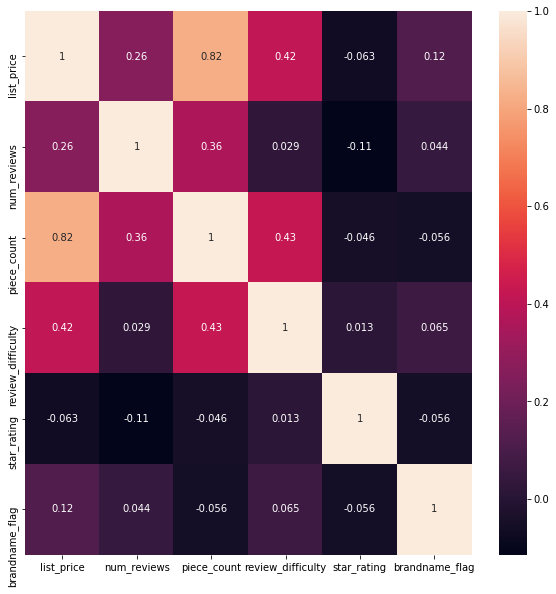

In [0]:
corr = lego.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr,annot=True)

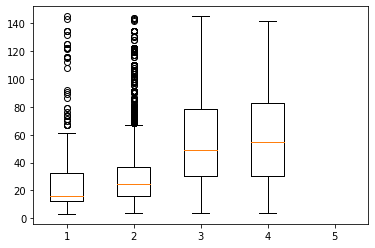

In [0]:
# Box plot for prices for all review difficulties

very_easy_lego = lego[lego.review_difficulty == 1.0].list_price
easy_lego = lego[lego.review_difficulty == 2.0].list_price
average_lego = lego[lego.review_difficulty == 3.0].list_price
hard_lego = lego[lego.review_difficulty == 4.0].list_price
very_hard_lego = lego[lego.review_difficulty == 5.0].list_price

toplot = [very_easy_lego, easy_lego, average_lego, hard_lego, very_hard_lego]

plt.boxplot(toplot)
plt.show()

In [0]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [0]:
## Range of difficulty levels across each continent?

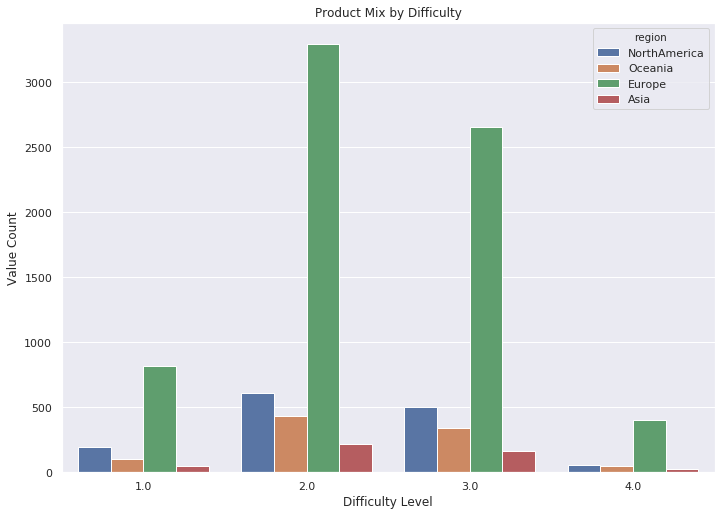

In [0]:
fig = sns.countplot(data=lego, x="review_difficulty", hue="region")
plt.xlabel("Difficulty Level")
plt.ylabel("Value Count")
plt.title("Product Mix by Difficulty")
sns.set(rc={'figure.figsize':(18,6)})
plt.show(fig)

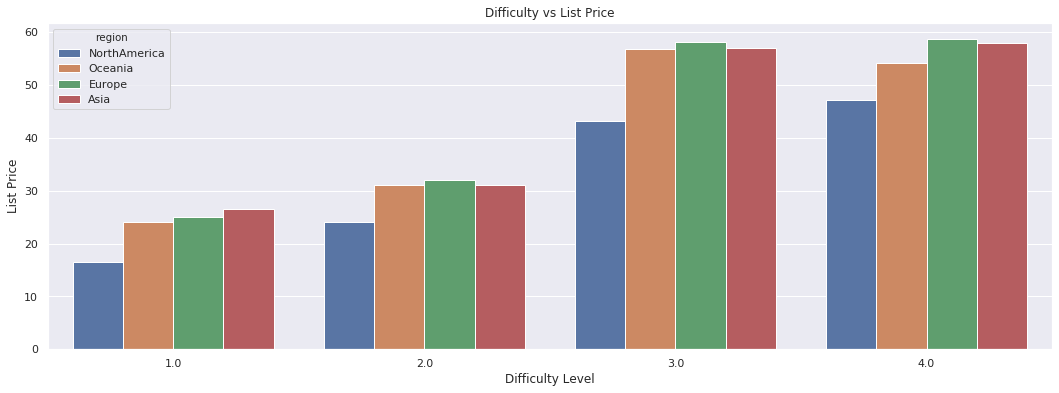

In [0]:
fig = sns.barplot(x="review_difficulty", y="list_price", data = lego, ci=None, hue="region")
plt.xlabel("Difficulty Level")
plt.ylabel("List Price")
plt.title("Difficulty vs List Price")
sns.set(rc={'figure.figsize':(18,8)})
plt.show(fig)

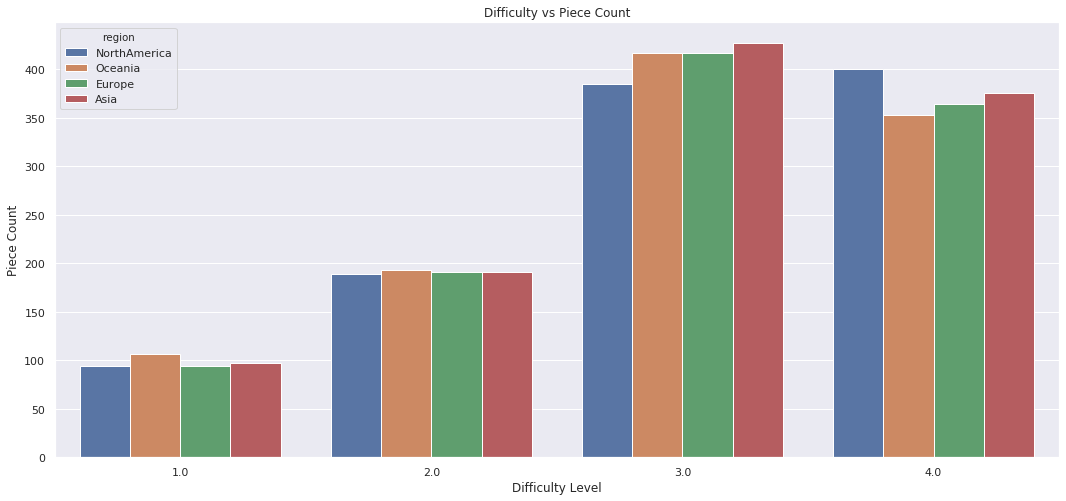

In [0]:
fig = sns.barplot(x="review_difficulty", y="piece_count", data = lego, ci=None, hue="region")
plt.xlabel("Difficulty Level")
plt.ylabel("Piece Count")
plt.title("Difficulty vs Piece Count")
sns.set(rc={'figure.figsize':(18,8)})
plt.show(fig)

## Age group across each continent?

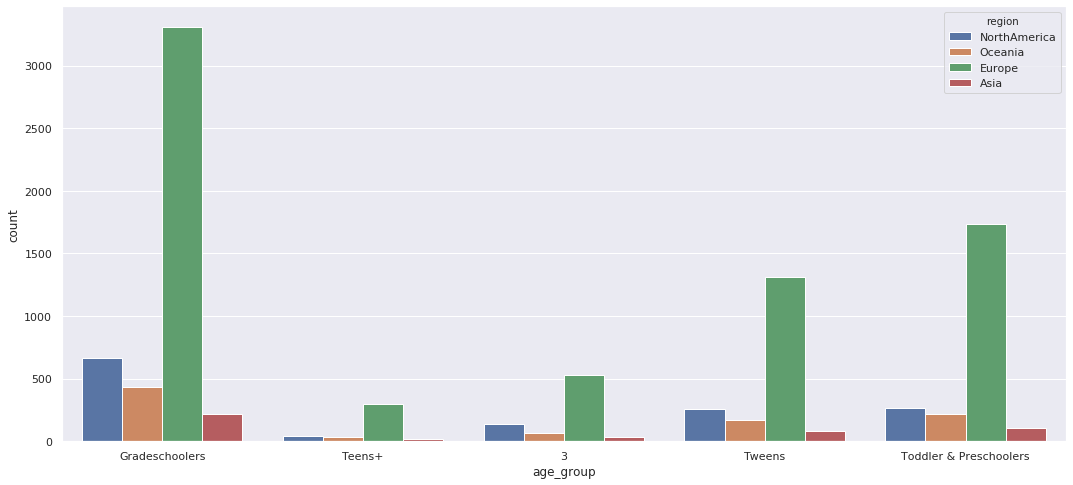

In [0]:
sns.countplot(data=lego, x="age_group", hue="region")

## What is the average price range for each difficulty level? Is there any relationship between price and difficulty level? Does this vary drastically across the continents?

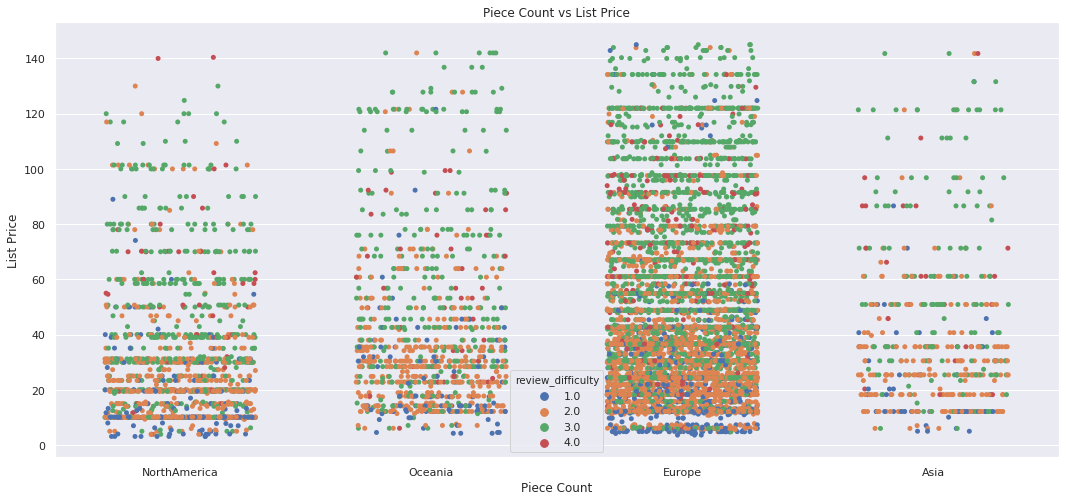

In [0]:

fig = sns.stripplot(x="region", y="list_price", data = lego,  hue="review_difficulty",jitter=0.3)
plt.xlabel("Piece Count")
plt.ylabel("List Price")
plt.title("Piece Count vs List Price")
sns.set(rc={'figure.figsize':(18,8)})
plt.show(fig)

## What is the relationship between piece count and price of Lego set?

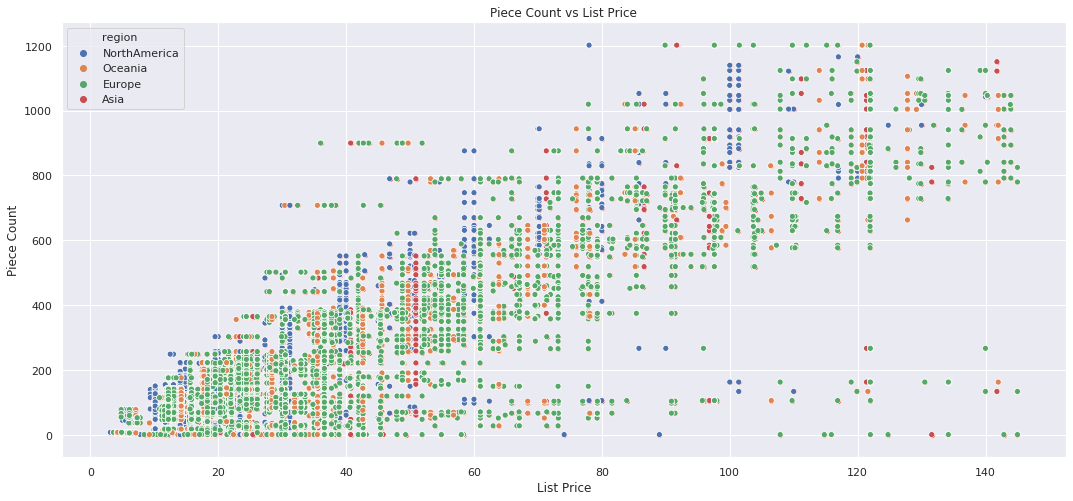

In [0]:
sns.scatterplot(x="list_price", y="piece_count", data=lego,color="red")
fig = sns.scatterplot(x="list_price", y="piece_count", data = lego, ci=None, hue="region")
plt.ylabel("Piece Count")
plt.xlabel("List Price")
plt.title("Piece Count vs List Price")
sns.set(rc={'figure.figsize':(18,8)})
plt.show(fig)

## What is the relationship between piece count and difficulty level?

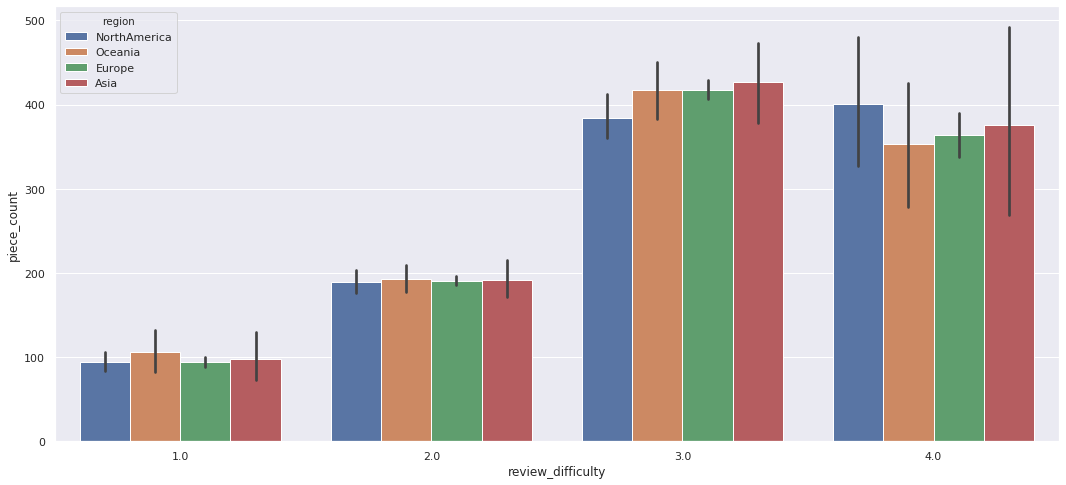

In [0]:
sns.barplot(data=lego, x="review_difficulty", y="piece_count", hue="region")

## How do difficulty level and piece count relate to product price?

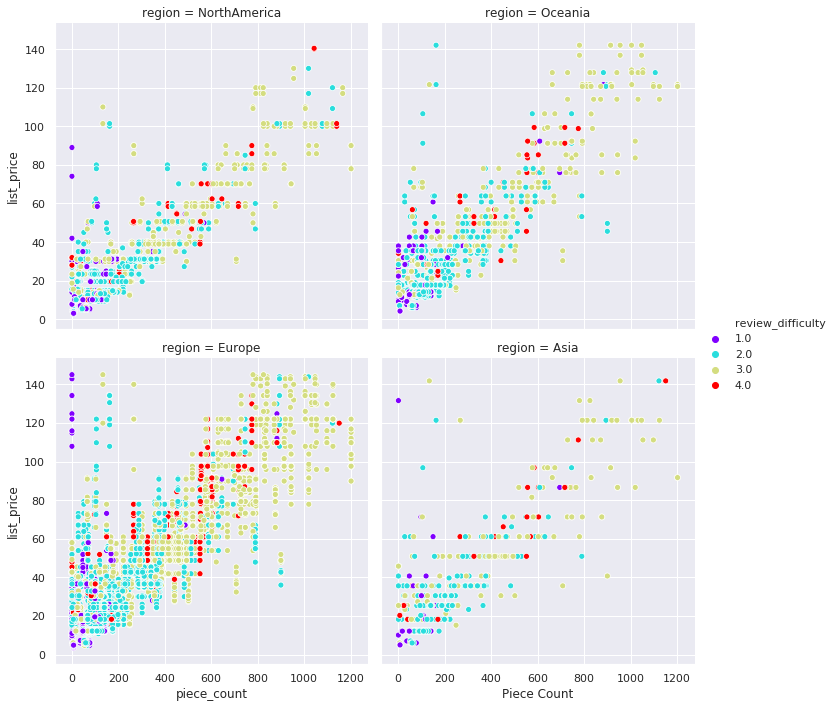

In [0]:
fig = sns.relplot(x="piece_count", y="list_price", data=lego,hue="review_difficulty", col="region", col_wrap=2,palette="rainbow")
plt.xlabel("Piece Count")
plt.ylabel("List Price")
sns.set(rc={'figure.figsize':(18,8)})
plt.show(fig)

## Which age group has the highest average price in each continent?

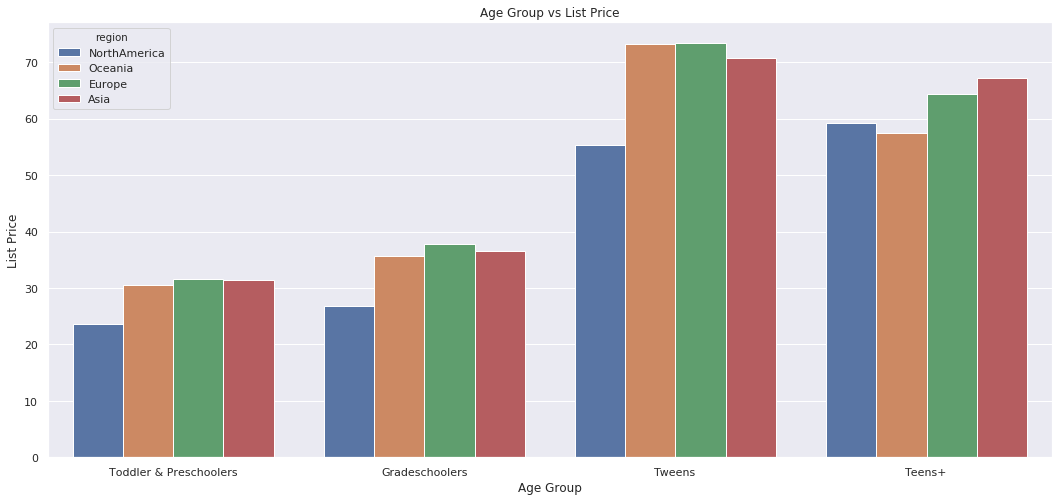

In [0]:
fig = sns.barplot(x="age_group", y="list_price", data = lego, ci=None, hue="region",order=["Toddler & Preschoolers","Gradeschoolers","Tweens","Teens+"])
plt.xlabel("Age Group")
plt.ylabel("List Price")
plt.title("Age Group vs List Price")
sns.set(rc={'figure.figsize':(18,8)})
plt.show(fig)

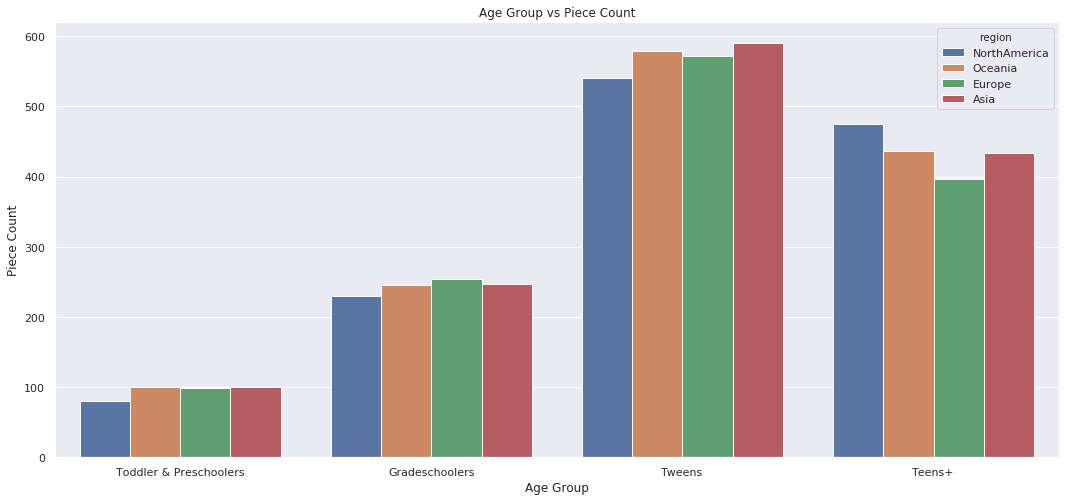

In [0]:
fig = sns.barplot(x="age_group", y="piece_count", data = lego, ci=None, hue="region",order=["Toddler & Preschoolers","Gradeschoolers","Tweens","Teens+"])
plt.xlabel("Age Group")
plt.ylabel("Piece Count")
plt.title("Age Group vs Piece Count")
sns.set(rc={'figure.figsize':(18,8)})
plt.show(fig)

## More Graphs

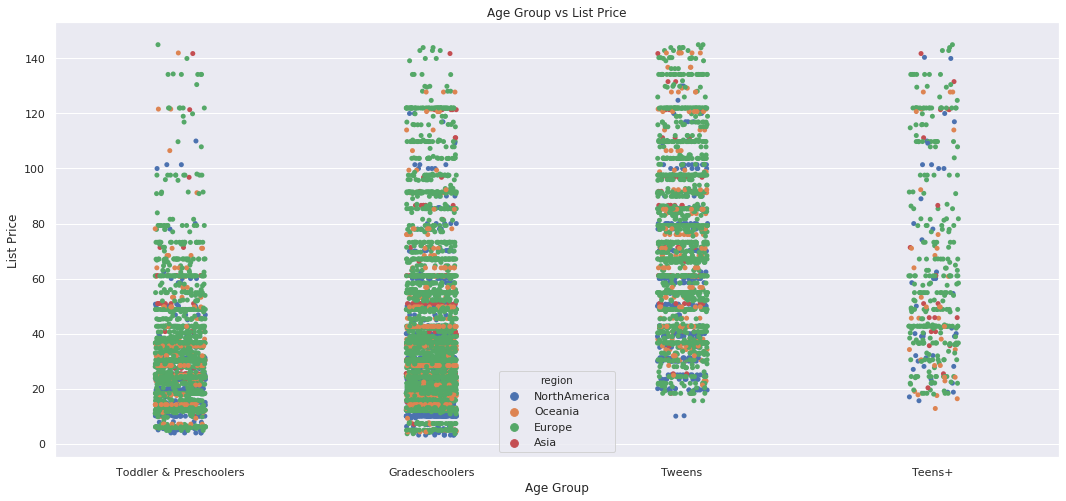

In [0]:
fig = sns.stripplot(x="age_group", y="list_price", data = lego, hue="region",order=["Toddler & Preschoolers","Gradeschoolers","Tweens","Teens+"])
plt.xlabel("Age Group")
plt.ylabel("List Price")
plt.title("Age Group vs List Price")
sns.set(rc={'figure.figsize':(18,8)})
plt.show(fig)

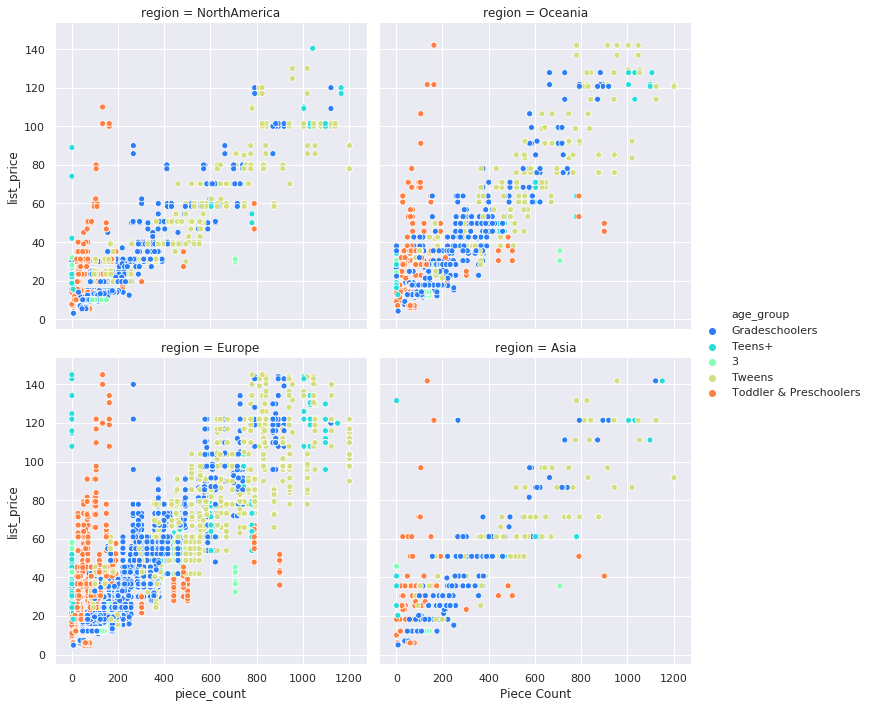

In [0]:
fig = sns.relplot(x="piece_count", y="list_price", data=lego,hue="age_group", col="region", col_wrap=2,palette="rainbow")
plt.xlabel("Piece Count")
plt.ylabel("List Price")
sns.set(rc={'figure.figsize':(18,8)})
plt.show(fig)

In [0]:
Europe=lego[lego.region=="Europe"]
Europe.head()

,ages,list_price,num_reviews,piece_count,review_difficulty,star_rating,theme_name,country,brandname_flag,age_group,region
1387,12+,121.9878,23.0,1032.0,3.0,4.6,Architecture,AT,0,Teens+,Europe
1388,12+,85.3878,14.0,744.0,4.0,4.6,Architecture,AT,0,Teens+,Europe
1389,12+,73.1878,7.0,597.0,3.0,4.9,Architecture,AT,0,Teens+,Europe
1390,12+,60.9878,24.0,780.0,3.0,4.7,Architecture,AT,0,Teens+,Europe
1392,12+,48.7878,23.0,468.0,3.0,4.7,Architecture,AT,0,Teens+,Europe


In [0]:
cluster_data = lego[['list_price']]

In [0]:
wcss = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
  kmeans.fit(cluster_data.values)
  wcss.append(kmeans.inertia_)

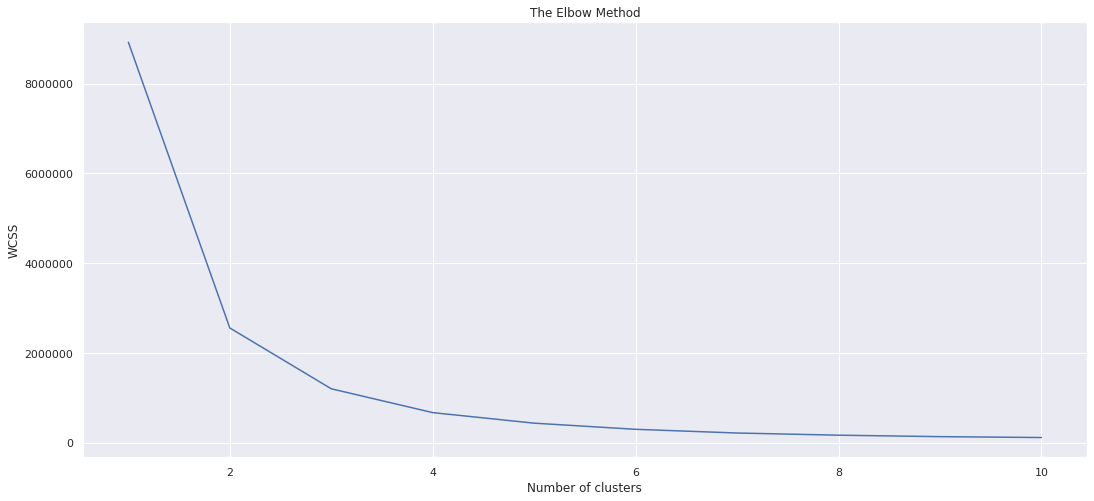

In [0]:
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [0]:
km_lego = KMeans(4, init='k-means++', random_state=0)

In [0]:
km_lego.fit(cluster_data.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [0]:
lego['price_segment'] = km_lego.predict(cluster_data.values)

In [0]:
lego

,ages,list_price,num_reviews,piece_count,review_difficulty,star_rating,theme_name,country,brandname_flag,age_group,region,price_segment
0,6-12,29.9900,2.0,277.0,3.0,4.500000,Angry Birds™,US,1,2,NorthAmerica,2
1,6-12,19.9900,2.0,168.0,2.0,5.000000,Angry Birds™,US,1,2,NorthAmerica,0
2,6-12,12.9900,11.0,74.0,2.0,4.300000,Angry Birds™,US,1,2,NorthAmerica,0
3,12+,99.9900,23.0,1032.0,3.0,4.600000,Architecture,US,0,4,NorthAmerica,3
4,12+,79.9900,14.0,744.0,4.0,4.600000,Architecture,US,0,4,NorthAmerica,1
5,12+,59.9900,7.0,597.0,3.0,4.900000,Architecture,US,0,4,NorthAmerica,1
7,12+,49.9900,24.0,780.0,3.0,4.700000,Architecture,US,0,4,NorthAmerica,3
8,12+,39.9900,23.0,468.0,3.0,4.700000,Architecture,US,0,4,NorthAmerica,1
9,12+,39.9900,11.0,444.0,3.0,4.800000,Architecture,US,0,4,NorthAmerica,1
10,12+,39.9900,14.0,386.0,3.0,4.400000,Architecture,US,0,4,NorthAmerica,2


In [0]:
lego.groupby('price_segment').list_price.mean()

price_segment
0     37.651583
1    110.625137
2     16.820121
3     67.019025
Name: list_price, dtype: float64

In [0]:
price_chart = {
    2: 'Low Price',
    3: 'High Price',
    0: 'Moderate Price',
    1: 'Premium Price'
}

In [0]:
lego.price_segment = lego.price_segment.map(price_chart)

In [0]:
color_map = {
    'Low Price': 'r',
    'Moderate Price': 'g',
    'High Price': 'b',
    'Premium Price': 'y'
}

In [0]:
def makeCluster(d, x, y, centroid=True):
    fig, ax = plt.subplots(figsize=(12,6))
    for price in price_chart.values():
        color = color_map[price]
        if d[d.price_segment == price].list_price.count() > 0:
            d[d.price_segment == price].plot(kind='scatter', x=x, y=y, label=price,ax=ax, color=color)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='lower right')
    plt.show()

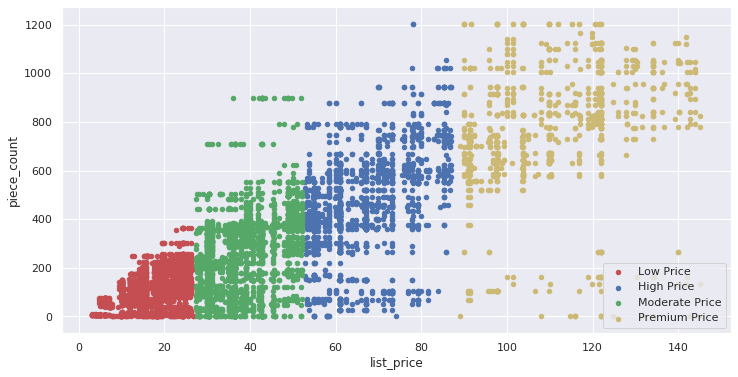

In [0]:
makeCluster(lego, 'list_price', 'piece_count')

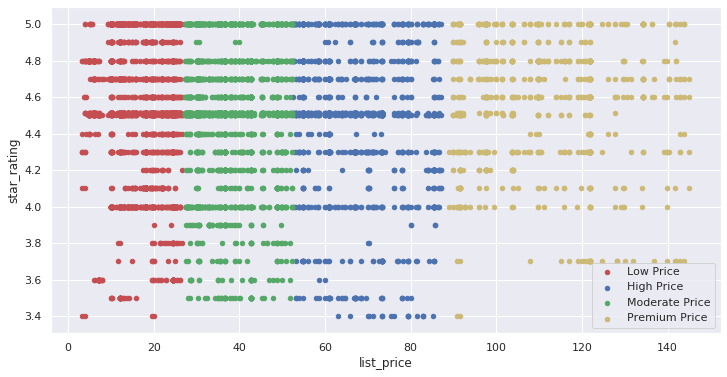

In [0]:
makeCluster(lego, 'list_price', 'star_rating')

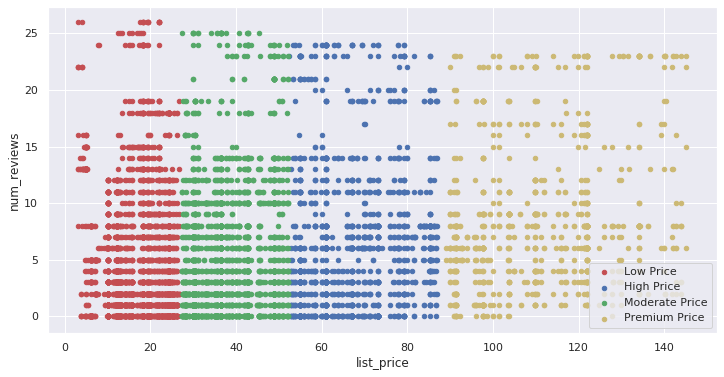

In [0]:
makeCluster(lego, 'list_price', 'num_reviews')

In [0]:
lego.head()

,ages,list_price,num_reviews,piece_count,review_difficulty,star_rating,theme_name,country,brandname_flag,age_group,region,price_segment
0,6-12,29.99,2.0,277.0,3.0,4.5,Angry Birds™,US,1,Gradeschoolers,NorthAmerica,Moderate Price
1,6-12,19.99,2.0,168.0,2.0,5.0,Angry Birds™,US,1,Gradeschoolers,NorthAmerica,Low Price
2,6-12,12.99,11.0,74.0,2.0,4.3,Angry Birds™,US,1,Gradeschoolers,NorthAmerica,Low Price
3,12+,99.99,23.0,1032.0,3.0,4.6,Architecture,US,0,Teens+,NorthAmerica,Premium Price
4,12+,79.99,14.0,744.0,4.0,4.6,Architecture,US,0,Teens+,NorthAmerica,High Price


In [0]:
from sklearn.preprocessing import StandardScaler
features = ['review_difficulty', 'piece_count','star_rating']
# Separating out the features
x = lego.loc[:, features].values
# Separating out the target
y = lego.loc[:,['price_segment']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,0.622675,0.108782
1,-0.679762,-1.092406
2,-0.833897,0.760260
3,2.678985,-0.070721
4,2.818274,-0.246168


In [0]:
finalDf = pd.concat([principalDf, lego[['price_segment']]], axis = 1)
finalDf.head()

,principal component 1,principal component 2,price_segment
0,0.622675,0.108782,Moderate Price
1,-0.679762,-1.092406,Low Price
2,-0.833897,0.760260,Low Price
3,2.678985,-0.070721,Premium Price
4,2.818274,-0.246168,High Price


NameError: ignored

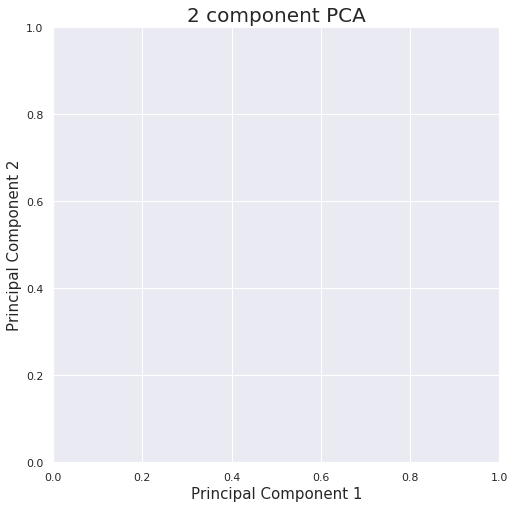

In [0]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
price_segment = ['Low Price', 'Moderate Price', 'High Price', 'Premium Price']
colors = ['r', 'g', 'b','y']
for price_segment, color in zip(targets,colors):
    indicesToKeep = finalDf['price_segment'] == price_segment
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [0]:
pca.explained_variance_ratio_

array([0.47626291, 0.33426779])

In [0]:
#Explained variance of 68.35% - first with 43.3% and 2nd with 25.1%
#If you move below 85% of the variance, you've lost to much data to move forward with PCA
#went from a 4-dimensional space to a 2-dimensional space 

0.6835